In [1]:
import numpy as np
from scipy import optimize

### Исходные данные

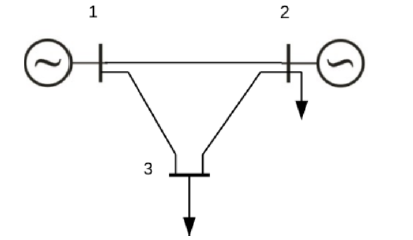

In [2]:
#Сопротивления ветвей
Z12 = 12 + 75.5j
Z13 = 20 + 66.1j
Z23 = 8.3 + 52.9j
# ПРИМЕЧАНИЕ: Напряжения и мощности переведны в фазные величины
# Мощности в узлах
P2 = -20 * 1e6 / 3
S3 = (100 + 40j)*1e6 / 3
# Для простоты проверки второй задачи давайте зададимся:
V1 = 230_000 / np.sqrt(3)
d1 = 0
V2 = 227000/ np.sqrt(3)

### Решение

Система уравенений по МУН:
$$
 Y_{11}  \cdot \dot U_{1} - Y_{12}\cdot \dot U_{2} - Y_{13}\cdot \dot U_{3} = \dot J_{1}\\
 -Y_{12}  \cdot \dot U_{1} + Y_{22}\cdot \dot U_{2} - Y_{23}\cdot \dot U_{3} = \dot J_{2}\\
 -Y_{13}  \cdot \dot U_{1} - Y_{23}\cdot \dot U_{2} + Y_{33}\cdot \dot U_{3} = \dot J_{3}
$$

In [3]:
#Рассчитаем проводимости
Y12 = 1 / Z12
Y13 = 1 / Z13
Y23 = 1 / Z23
Y11 = Y12 + Y13
Y22 = Y12 + Y23
Y33 = Y23 + Y13

In [4]:
#Матрица проводимостей
Y = np.array([[Y11, -Y12, -Y13],
             [-Y12, Y22, -Y23],
             [-Y13, -Y23, Y33]])

Узел 1 - базисно-балансирующий. Исключим балансирущий узел из системы уравнений:
$$
 w_{I2} = -Y_{12}  \cdot \dot U_{1} + Y_{22}\cdot \dot U_{2} - Y_{23}\cdot \dot U_{3} - \dot J_{2}\\
 w_{I3} = -Y_{13}  \cdot \dot U_{1} - Y_{23}\cdot \dot U_{2} + Y_{33}\cdot \dot U_{3} - \dot J_{3}
$$

Перепишем систему уравнений в форме баланса мощностей:
$$
 w_{S2} = -Y_{12}  \cdot \dot U_{1} \cdot \overset{*}{U_{2}} + Y_{22}\cdot U_{2}^2 - Y_{23}\cdot \dot U_{3} \cdot \overset{*}{U_{2}} - \dot S_{2}\\
 w_{S3} = -Y_{13}  \cdot \dot U_{1} \cdot \overset{*}{U_{3}}- Y_{23}\cdot \dot U_{2} \cdot \overset{*}{U_{3}} + Y_{33}\cdot U_{3}^2  - \dot S_{3}
$$

Напишем оптимизируемую функцию. При этом учитываем следующее:
- каждое уравнение делится на вещественную и мнимую часть
- напряжение в узле 2 задано по модулю и не известно по углу, поэтому модуль V2 принимаем известным, а угол d2 - переменная
- активная мощность в узле 2 известна, реактивную нужно найти 

In [5]:
def fun(v):
    """Функция расчета баланса мощностей
    
    param: v - [Q2, d2, re U3, im U3]
    
    return: w - баланс мощностей в узлах 2 и 3
    """
    
    v1 = V1
    v2 = V2 * np.exp(1j*v[1])
    v3 = v[2] + 1j*v[3]
    res1 = np.real(Y22*np.abs(v2)**2 - Y23*v3*np.conj(v2) - P2 - 1j * v[0] - Y12*v1*np.conj(v2))
    res2 = np.imag(Y22*np.abs(v2)**2 - Y23*v3*np.conj(v2) - P2 - 1j * v[0] - Y12*v1*np.conj(v2))
    res3 = np.real(-Y23*v2*np.conj(v3) + Y33*np.abs(v3)**2 - S3 - Y13*v1*np.conj(v3))
    res4 = np.imag(-Y23*v2*np.conj(v3) + Y33*np.abs(v3)**2 - S3 - Y13*v1*np.conj(v3))
    return np.array((res1, res2, res3, res4))

Поиск решения нелинейного уравнения

In [6]:
sol = optimize.root(fun, np.array((0, 0, V1, 0)), method='hybr')

In [7]:
sol

 message: The solution converged.
 success: True
  status: 1
     fun: [ 3.465e-07  1.028e-04  2.235e-06 -1.186e-05]
       x: [-3.176e+05  3.637e-02  1.299e+05  1.082e+04]
    nfev: 13
    fjac: [[-3.173e-07  1.000e+00 -4.162e-04  1.913e-03]
           [-8.596e-01  2.004e-05  5.014e-01  9.846e-02]
           [ 1.699e-02 -1.955e-03 -1.645e-01  9.862e-01]
           [-5.107e-01 -9.938e-05 -8.494e-01 -1.329e-01]]
       r: [-9.763e-01  7.014e+07  3.272e+03  1.547e+01 -6.347e+08
            2.622e+02  4.325e+03 -4.306e+03 -6.582e+01 -2.521e+03]
     qtf: [-2.712e-02 -2.125e-06  2.566e-03  1.224e-04]

### Результат

In [8]:
V1_res = V1
V2_res = V2 * np.exp(1j*sol.x[1]) #sol.x[0] + 1j * sol.x[1] #V2 * np.exp(1j*sol.x[1])
V3_res = sol.x[2] + 1j * sol.x[3]
V_res = np.array((V1_res, V2_res, V3_res))

In [9]:
print(f'Количество итераций: {sol.nfev}')

Количество итераций: 13


In [10]:
print("Напряжения в узлах:")
for ind, v  in enumerate(V_res):
    print(f'U{ind+1} = {np.abs(v) * np.sqrt(3) / 1000:.1f}, В; {np.rad2deg(np.angle(v)):.1f}, гр')

Напряжения в узлах:
U1 = 230.0, В; 0.0, гр
U2 = 227.0, В; 2.1, гр
U3 = 225.7, В; 4.8, гр


In [11]:
#Мощности в узлах:
S_res = np.dot(Y , V_res) * np.conj(V_res)*3 / 1e6
for ind, s  in enumerate(S_res):
    print(f'P{ind+1} = {np.real(s):.1f}, МВт; Q{ind+1} = {np.imag(s):.1f}, Мвар')

P1 = -77.9, МВт; Q1 = -47.4, Мвар
P2 = -20.0, МВт; Q2 = -1.0, Мвар
P3 = 100.0, МВт; Q3 = 40.0, Мвар


### Проверка

Проверим вручную, рассчитав мощность в узле

In [12]:
# Узел 1
((V1_res -V3_res) / Z13 + (V1_res-V2_res) / Z12) * np.conj(V1_res)*3 / 1e6

(-77.93189134799346-47.36946188783993j)

In [13]:
# Узел 2
((V2_res -V3_res) / Z23 + (V2_res-V1_res) / Z12) * np.conj(V2_res)*3 / 1e6

(-19.999999999999-0.9527717584667065j)

In [14]:
# Узел 3
((V3_res -V1_res) / Z13 + (V3_res-V2_res) / Z23) * np.conj(V3_res)*3 / 1e6

(100.00000000000661+39.999999999964786j)

### Список литературы
1. Меркурьев Г.В., Шаргин Ю.М. Устойчивость энергосистем (Шаргин Ю.М. читал нам курс лекций по данной теме, поэтому обратился к этому труду)